### Load the Human Data

In [ ]:
import os
import glob
import re
import scipy.io
import pandas as pd
import numpy as np

# 폴더 경로
data_dir = '/Users/ijimin/Downloads/reliabiliity-main/Data/S_001'

# 파일 경로 목록
mat_files = glob.glob(os.path.join(data_dir, "trial_*.mat"))

# 숫자 기준 정렬
mat_files = sorted(mat_files, key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

# 결과 저장 리스트
rows = []

for file_path in mat_files:
    try:
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        curr = mat['curr_trial_data']

        # 필수 필드가 전부 있는지 검사
        if not hasattr(curr, "PURSUIT") or not hasattr(curr, "reward_info") or not hasattr(curr, "REPORT") or not hasattr(curr, "eels"):
            print(f"Skipping {file_path}: missing main fields")
            continue

        if not hasattr(curr.PURSUIT, "left_fish_caught") or not hasattr(curr.PURSUIT, "right_fish_caught"):
            print(f"Skipping {file_path}: missing fish_caught fields")
            continue

        if not hasattr(curr.reward_info, "reward_given"):
            print(f"Skipping {file_path}: missing reward_given field")
            continue

        if not hasattr(curr.REPORT, "reported_reliability") or not hasattr(curr.REPORT, "reported_reliabiliity") or not hasattr(curr.REPORT, "target_eel_idx"):
            print(f"Skipping {file_path}: missing report fields")
            continue

        if not hasattr(curr.eels[0], "reliability") or not hasattr(curr.eels[1], "reliability"):
            print(f"Skipping {file_path}: missing eel reliability")
            continue

        # 데이터 추출
        if np.array_equal(curr.eels[0].eel_col, [0,0,255]): # 색상기준으로 eel idx 매칭 (eel1: [0, 0, 255], eel2: [157, 0, 255])
            eel1 = curr.eels[0]
            eel2 = curr.eels[1]
        else:
            eel1 = curr.eels[1]
            eel2 = curr.eels[0]
        report = curr.REPORT
        pursuit = curr.PURSUIT

        row = {
            "trial_idx": curr.trial_idx,
            "n1": curr.PURSUIT.left_fish_caught if np.array_equal(eel1.initial_side, 1) else curr.PURSUIT.right_fish_caught,
            "n2": curr.PURSUIT.right_fish_caught if np.array_equal(eel2.initial_side, 2) else curr.PURSUIT.left_fish_caught,
            "reward": bool(curr.reward_info.reward_given),
            "eel1_reliability": eel1.reliability,
            "eel2_reliability": eel2.reliability,
            "eel1_reliabiliity": eel1.reliabiliity,
            "eel2_reliabiliity": eel2.reliabiliity,
            "reported_reliability": report.reported_reliability,
            "reported_reliabiliity": report.reported_reliabiliity,
            "target_eel_idx": 1 if np.array_equal(report.target_eel_color, [0,0,255]) else 2     
        }

        rows.append(row)

    except Exception as e:
        print(f"Failed to load {file_path}: {e}")

# DataFrame으로 변환
df = pd.DataFrame(rows)

# 결과 확인
print(df.iloc[28:32, :])     # 두 번째 행, 모든 열 (빠져있는 trial 반영되었는지 확인)
print(f"총 사용된 trial 수: {len(df)} / {len(mat_files)}")

Skipping /Users/ijimin/Downloads/Competency-main/Data/S_001/trial_30.mat: missing main fields
    trial_idx  n1  n2  reward  eel1_reliability  eel2_reliability  \
28         29   0   0   False               0.1              0.25   
29         31   1   1   False               0.1              0.25   
30         32   0   3   False               0.1              0.25   
31         33   0   0   False               0.1              0.25   

    eel1_competency  eel2_competency  reported_reliability  \
28         0.278316         0.387298                     0   
29         0.278316         0.387298                     0   
30         0.278316         0.387298                     0   
31         0.278316         0.387298                     0   

    reported_competency  target_eel_idx  
28                    0               1  
29                    0               2  
30                    0               1  
31                    0               2  
총 사용된 trial 수: 299 / 300


# Reliability

> ### Hypothesis
* H1: eel1 has higher reliability(0.25)
* H2: eel2 has higher reliability(0.25)

> ### Observation
* Rewarded(1) or not(0)

#### (1) 실제 Reliability

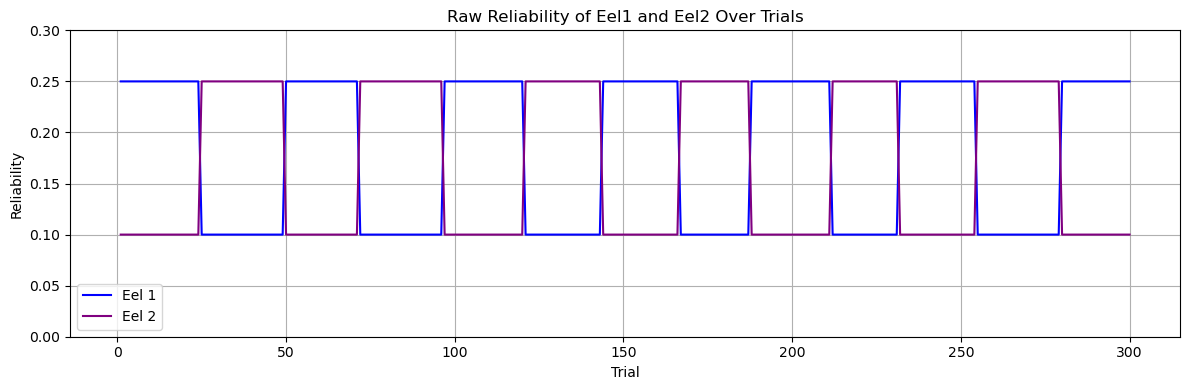

In [5]:
# (1) y축이 0~1로 설정해서 eel1과 eel2의 Raw Reliability 수치로 각각 나타내기

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.plot(df["trial_idx"], df["eel1_reliability"], label="Eel 1", color="blue")
plt.plot(df["trial_idx"], df["eel2_reliability"], label="Eel 2", color="purple")
plt.xlabel("Trial")
plt.ylabel("Reliability")
plt.title("Raw Reliability of Eel1 and Eel2 Over Trials")
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


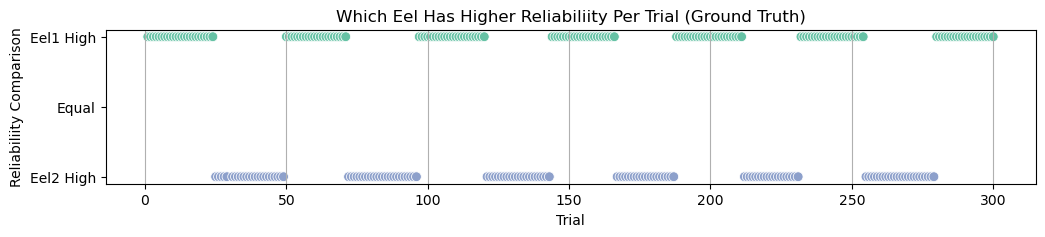

In [6]:
# (3) y축을 high, low로 설정해서 eel1과 eel2를 비교했을 때 뭐가 high, low인지 나타내기 (Categorical)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# eel1과 eel2의 reliabiliity 비교 결과 계산
df["reliabiliity_diff"] = np.sign(df["eel1_reliability"] - df["eel2_reliability"])
df["reliabiliity_label"] = df["reliabiliity_diff"].map({1: "Eel1 High", -1: "Eel2 High", 0: "Equal"})

# y축 순서 지정
order = ["Eel1 High", "Equal", "Eel2 High"]
df["reliabiliity_label"] = pd.Categorical(df["reliabiliity_label"], categories=order, ordered=True)

# 시각화
plt.figure(figsize=(12, 2))
sns.scatterplot(x="trial_idx", y="reliabiliity_label", data=df, hue="reliabiliity_label", palette="Set2", s=50, legend=False)
plt.title("Which Eel Has Higher Reliabiliity Per Trial (Ground Truth)")
plt.xlabel("Trial")
plt.ylabel("Reliabiliity Comparison")
plt.yticks(order)
plt.grid(True, axis='x')
# plt.tight_layout()
plt.show()



#### (2) Reported Reliability

##### (2-A) ##### Only Reported Reliability

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (가정) df 에는 ['trial_idx','reported_competency','target_eel_idx'] 컬럼이 있습니다.

# 1) 조건에 맞춰 'Eel1 High' / 'Eel2 High' 레이블 생성
cond = (
    ((df['reported_competency'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_competency_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')

# 2) 카테고리형으로 순서 고정
order = ['Eel1 High', 'Eel2 High']
df['reported_competency_label'] = pd.Categorical(
    df['reported_competency_label'],
    categories=order,
    ordered=True
)

# 3) 시각화
plt.figure(figsize=(12,2))
sns.scatterplot(
    x='trial_idx',
    y='reported_competency_label',
    data=df,
    hue='reported_competency_label',
    palette='Set2',
    s=50,
    legend=False
)
plt.yticks(order)
plt.xlabel('Trial')
plt.ylabel('Reported Competency')
plt.title('Which Eel Was Reported High in Competency?')
plt.grid(True, axis='x')
plt.show()
